## Bitcoin Sentiment Analysis

This project, is a section of my final datascience bootcamp project where I built a model to forecast the future prices of Bitcoin. 

Information, particularly from mainstream media, twitter, and particular people like Elon Musk have been known to affect the price of crypto currency. 

The goal therefore for this particular project is to analyze bitcoin tweets, check it effect on the price and possibly use the sentiment analysis to make forecasts. 

### Import necessary libraries

In [1]:
import sys
import tweepy
import csv
import time
import numpy as np
from nltk.corpus import stopwords
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
from wordcloud import WordCloud, STOPWORDS
import nltk
import emoji
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set()
%matplotlib inline


### Vader Sentiment Intensity Analyzer

In [2]:
import requests
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()
analyser.polarity_scores("Bitcoin is the BOMB!!!")

{'neg': 0.0, 'neu': 0.381, 'pos': 0.619, 'compound': 0.7074}

In [3]:
def sentiment_analyzer_scores(text):
    score = analyser.polarity_scores(text)
    lb = score['compound']
    if lb >= 0.05:
        return 1
    elif (lb > -0.05) and (lb < 0.05):
        return 0
    else:
        return -1
    
sentiment_analyzer_scores("Bitcoin is the BOMB!!!")

1

### Googletrans
Googletrans is a free and unlimited python library that implemented Google Translate API. This uses the Google Translate Ajax API to make calls to such methods as detect and translate.

In [4]:
from google_trans_new import google_translator  

translator = google_translator()  
text = translator.translate('Bitcoin ist die BOMBE',lang_tgt='en')  
print(text)
print("\n")
analyser.polarity_scores(text)

Bitcoin is the BOMB 




{'neg': 0.0, 'neu': 0.429, 'pos': 0.571, 'compound': 0.6124}

In [5]:
def sentiment_analyzer_scores(text, engl=True):
    if engl:
        trans = text
    else:
        trans = translator.translate(text,lang_tgt='en')

    score = analyser.polarity_scores(trans)
    lb = score['compound']
    if lb >= 0.05:
        return 1
    elif (lb > -0.05) and (lb < 0.05):
        return 0
    else:
        return -1
sentiment_analyzer_scores(text)

1

### Get & save bitcoin tweets

In [6]:
# load twitter credentials (hidden for security reasons)
ACCESS_TOKEN = 'YOUR ACCESS_TOKEN'
ACCESS_SECRET = 'YOUR ACCESS_SECRET'
CONSUMER_KEY = 'YOUR CONSUMER_KEY'
CONSUMER_SECRET = 'YOUR CONSUMER_SECRET'

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
api = tweepy.API(auth)

In [7]:
def twitter_stream_listener(file_name,
                            filter_track,
                            follow=None,
                            locations=None,
                            languages=None,
                            time_limit=20):
    
    class CustomStreamListener(tweepy.StreamListener):
        def __init__(self, time_limit):
            self.start_time = time.time()
            self.limit = time_limit
            # self.saveFile = open('abcd.json', 'a')
            super(CustomStreamListener, self).__init__()
            
        def on_status(self, status):
            if (time.time() - self.start_time) < self.limit:
                print(".", end="")
                # Writing status data
                with open(file_name, 'a', encoding='utf-8') as f:
                    writer = csv.writer(f)
                    writer.writerow([
                        status.author.screen_name, status.created_at,
                        status.text
                    ])
            else:
                print("\n\n[INFO] Closing file and ending streaming")
                return False
            
        def on_error(self, status_code):
            if status_code == 420:
                print('Encountered error code 420. Disconnecting the stream')
                # returning False in on_data disconnects the stream
                return False
            else:
                print('Encountered error with status code: {}'.format(
                    status_code))
                return True  # Don't kill the stream
            
        def on_timeout(self):
            print('Timeout...')
            return True  # Don't kill the stream
    # Writing csv titles
    print(
        '\n[INFO] Open file: [{}] and starting {} seconds of streaming for {}\n'
        .format(file_name, time_limit, filter_track))
    with open(file_name, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['author', 'date', 'text'])
    
    streamingAPI = tweepy.streaming.Stream(
        auth, CustomStreamListener(time_limit=time_limit))
    streamingAPI.filter(
        track=filter_track,
        follow=follow,
        locations=locations,
        languages=languages,
    )
    f.close()

In [8]:
filter_track = ['bitcoin', 'btc']
file_name = 'btc_tweets.csv'
twitter_stream_listener(file_name, filter_track, time_limit=3600)


[INFO] Open file: [btc_tweets.csv] and starting 3600 seconds of streaming for ['bitcoin', 'btc']

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [9]:
df = pd.read_csv('btc_tweets.csv')
df.head

<bound method NDFrame.head of                 author                 date  \
0          Ayonbamigbe  2021-01-14 13:36:01   
1            luckyybro  2021-01-14 13:36:01   
2          NewsTwotter  2021-01-14 13:36:01   
3             zandelef  2021-01-14 13:36:01   
4        nickbbootlegs  2021-01-14 13:36:01   
...                ...                  ...   
22569  NepalBlockchain  2021-01-14 14:35:59   
22570          mungyo4  2021-01-14 14:35:59   
22571        Jason_gh1  2021-01-14 14:36:00   
22572          CTreets  2021-01-14 14:36:00   
22573     john03880440  2021-01-14 14:36:00   

                                                    text  
0      RT @cex_io: 🎁 Holidays are almost over but the...  
1      RT @PeergameGAW: #Bitcoin Giveaway\r\n\r\n$30 ...  
2      @TheCryptolarch @DoveyWan @earth @Bitcoin @tel...  
3      @Our_DA Am really grateful to God almighty for...  
4      RT wealth: Unlike stocks, Bitcoin trades 24/7,...  
...                                                

### Clean Saved Tweets

In [10]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

def clean_tweets(lst):
    # remove twitter Return handles (RT @xxx:)
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")
    # remove twitter handles (@xxx)
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")
    # remove URL links (httpxxx)
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")
    # remove special characters, numbers, punctuations (except for #)
    lst = np.core.defchararray.replace(lst, "[^a-zA-Z]", " ")
    return lst

"""
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',str(text))


def give_emoji_free_text(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text if not any(i in str for i in emoji_list)])
    return clean_text

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',str(text))
"""

def anl_tweets(lst, title='Tweets Sentiment', engl=True ):
    sents = []
    for tw in lst:
        try:
            st = sentiment_analyzer_scores(tw, engl)
            sents.append(st)
        except:
            sents.append(0)
    ax = sns.distplot(
        sents,
        kde=False,
        bins=3)
    ax.set(xlabel='Negative                Neutral                 Positive',
           ylabel='#Tweets',
          title="Tweets of @"+title)
    return sents

def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=21,
        colormap='jet',
        max_words=50,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");

C:\Users\pbamo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


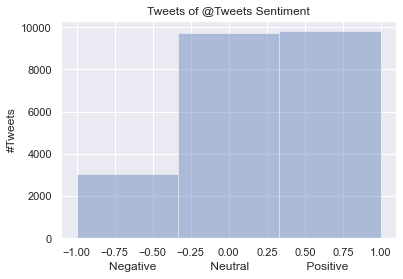

In [11]:
df['text'] = clean_tweets(df['text'])
df['text1']=df['text'].replace('\*','',regex=True)
df['text2'] = df['text'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
df['sent'] = anl_tweets(df.text2)

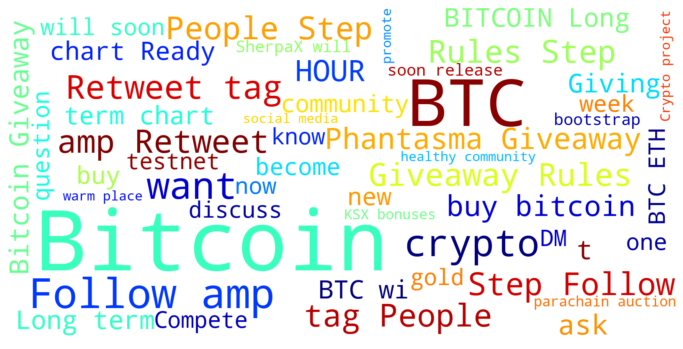

In [12]:
word_cloud(df.text2)

### Exploring positives and negatives tweets

In [13]:
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

# extracting hashtags from positive tweets
HT_positive = hashtag_extract(df['text'][df['sent'] == 1])

# extracting hashtags from negative tweets
HT_negative = hashtag_extract(df['text'][df['sent'] == -1])

# extracting hashtags from neutral tweets
HT_neutral = hashtag_extract(df['text'][df['sent'] == 0])

# unnesting list
HT_positive = sum(HT_positive,[])
HT_negative = sum(HT_negative,[])
HT_neutral = sum(HT_neutral,[])

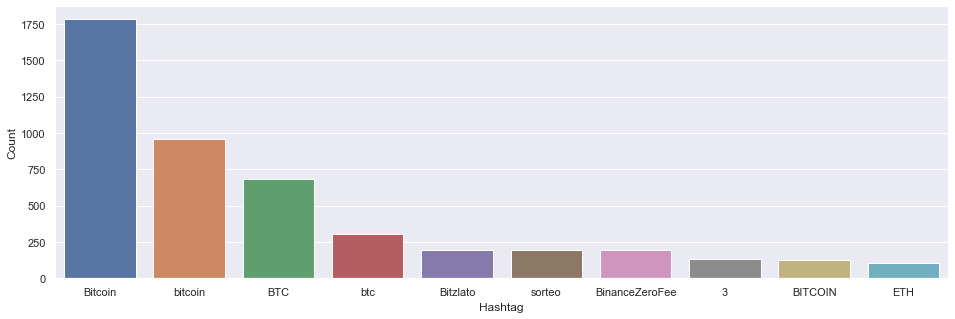

In [14]:
a = nltk.FreqDist(HT_neutral)
d = pd.DataFrame({'Hashtag':list(a.keys()), 'Count':list(a.values())})
# selecting top 10 most frequent hashtags
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x="Hashtag", y="Count")
ax.set(ylabel = 'Count')
plt.show()

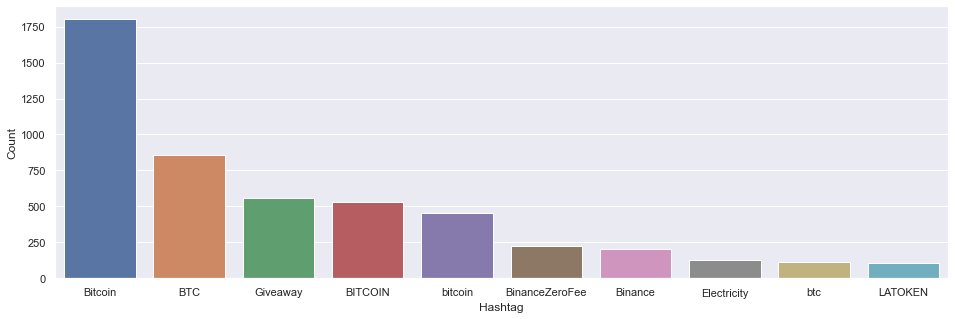

In [15]:
a = nltk.FreqDist(HT_positive)
d = pd.DataFrame({'Hashtag':list(a.keys()), 'Count':list(a.values())})
# selecting top 10 most frequent hashtags
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x="Hashtag", y="Count")
ax.set(ylabel = 'Count')
plt.show()

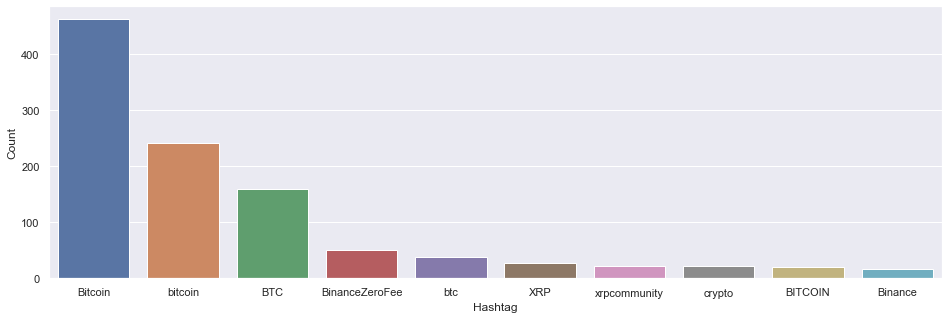

In [16]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag':list(a.keys()), 'Count':list(a.values())})
# selecting top 10 most frequent hashtags
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x="Hashtag", y="Count")
ax.set(ylabel = 'Count')
plt.show()

In [17]:
df
#further cleaning is needed to remove the emoji and chinese characters 

,author,date,text,text1,text2,sent
0,Ayonbamigbe,2021-01-14 13:36:01,🎁 Holidays are almost over but there are stil...,🎁 Holidays are almost over but there are stil...,Holidays are almost over but there are still...,1
1,luckyybro,2021-01-14 13:36:01,#Bitcoin Giveaway\r\n\r\n$30 in BSV to 1 luck...,#Bitcoin Giveaway\r\n\r\n$30 in BSV to 1 luck...,#Bitcoin Giveaway\r\n\r\n30 in BSV to 1 lucky...,1
2,NewsTwotter,2021-01-14 13:36:01,#promo #code #free #coin : #jicamet,#promo #code #free #coin : #jicamet,#promo #code #free #coin : #jicamet,1
3,zandelef,2021-01-14 13:36:01,Am really grateful to God almighty for bringi...,Am really grateful to God almighty for bringi...,Am really grateful to God almighty for bringi...,1
4,nickbbootlegs,2021-01-14 13:36:01,"RT wealth: Unlike stocks, Bitcoin trades 24/7,...","RT wealth: Unlike stocks, Bitcoin trades 24/7,...","RT wealth: Unlike stocks, Bitcoin trades 24/7,...",1
...,...,...,...,...,...,...
22569,NepalBlockchain,2021-01-14 14:35:59,Whale patiently waiting for you to panic sell...,Whale patiently waiting for you to panic sell...,Whale patiently waiting for you to panic sell...,-1
22570,mungyo4,2021-01-14 14:35:59,"‘기록’은 여러분께 의지를 가져다주고,\r\n‘시간’은 여러분께 이익을 가져가 줄...","‘기록’은 여러분께 의지를 가져다주고,\r\n‘시간’은 여러분께 이익을 가져가 줄...","기록은 여러분께 의지를 가져다주고,\r\n시간은 여러분께 이익을 가져가 줄 겁니다...",0
22571,Jason_gh1,2021-01-14 14:36:00,You can now buy bitcoin in Ghana via momo 🔥🔥...,You can now buy bitcoin in Ghana via momo 🔥🔥...,You can now buy bitcoin in Ghana via momo #B...,0
22572,CTreets,2021-01-14 14:36:00,Maybe it's more efficient to retweet my origin...,Maybe it's more efficient to retweet my origin...,Maybe its more efficient to retweet my origina...,1
